In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

#### Source sequence X

In [2]:
X_chars = [chr(asc_idx) for asc_idx in range(ord('a'), ord('z')+1)] \
    + ['<unk>', '<pad>', '<start>', '<end>']

X_lexicon = { ch:idx for idx, ch in enumerate(X_chars) }

In [3]:
m = 16
Tx = 50
X_lexicon_size = len(X_lexicon) # 30

# (m, Tx)
X = torch.randint(low=0, high=X_lexicon_size, size=(m, Tx))
print(f'{X.size() = }')
print(f'{X[0] = }')

X.size() = torch.Size([16, 50])
X[0] = tensor([ 3, 19, 12, 18,  9, 20, 10,  6,  8, 10,  4, 23, 13,  6, 10, 18, 22, 11,
        18, 12, 27,  6, 15, 23, 19,  4, 28, 21, 18,  5,  3,  6,  0, 16, 15,  5,
         5, 26, 25, 29, 15, 21, 16, 28,  0, 17, 27,  9, 16, 29])


#### Target sequence Y

In [4]:
Y_chars = [chr(asc_idx) for asc_idx in range(ord('0'), ord('9')+1)] \
    + ['<unk>', '<pad>', '<start>', '<end>']
Y_lexicon = { ch:idx for idx, ch in enumerate(Y_chars) }

In [5]:
m = 16
Ty = 40
Y_lexicon_size = len(Y_lexicon) # 14

# (m, Ty)
Y = torch.randint(low=0, high=Y_lexicon_size, size=(m, Ty))
print(f'{Y.size() = }')
print(f'{Y[0] = }')

Y.size() = torch.Size([16, 40])
Y[0] = tensor([ 5,  3,  0, 10,  2,  5,  9, 13, 10, 11,  7,  9, 11,  7, 10,  7,  3,  0,
        11,  2,  0,  4,  6,  4,  2,  4, 10, 12,  8,  5,  8,  0,  0,  2,  7, 10,
         0,  3,  3, 10])


# 1. Components
[https://arxiv.org/pdf/1706.03762v5.pdf](https://arxiv.org/pdf/1706.03762v5.pdf)

<img src="assets/transformer_transformer.png" width="400">


### 1.1 Embedding
- Encode **word meaning info**

In [6]:
class Embbeding(nn.Module):
    def __init__(self, lexicon_size, embed_dim):
        super(Embbeding, self).__init__()

        # Emb
        self.embedding = nn.Embedding(
            num_embeddings=lexicon_size,
            embedding_dim=embed_dim)

    def forward(self, inp):
        """
        Arguments:
            inp (Long tensor(m, T))         : Input sequence, categorical Long
                m : batch size
                T : sequence length
        Returns:
            emb (tensor(m, T, embed_dim))   : Embbeding sequence
        """
        # (m, T) -> (m, T, emb_dim)
        return self.embedding(inp)

In [7]:
embed_x = Embbeding(
    lexicon_size=X_lexicon_size,
    embed_dim=64)
X_emb = embed_x(X)

# (m, Tx, emb_dim)
print(f'{X_emb.size() = }')

X_emb.size() = torch.Size([16, 50, 64])


In [8]:
embed_y = Embbeding(
    lexicon_size=Y_lexicon_size,
    embed_dim=64)
Y_emb = embed_y(Y)

# (m, Ty, emb_dim)
print(f'{Y_emb.size() = }')

Y_emb.size() = torch.Size([16, 40, 64])


### 1.2 Positional Encoder
- Encode **word positioning info** (pos of a word in a sentence)
- PE = a matrix size (Tx, emb_dim)

$$\begin{cases}
\text{PE(pos, 2i)} = \sin \left(\frac{\text{pos}}{10000^{2i / d}} \right) \text{ (even i)} \\
\text{PE(pos, 2i + 1)} = \cos \left(\frac{\text{pos}}{10000^{2i / d}} \right) \text{ (odd i)}
\end{cases}$$

- X_embed_pe = A*embed + PE
    + Amplify embed values to prevent embedding info supressed by PE info after adding

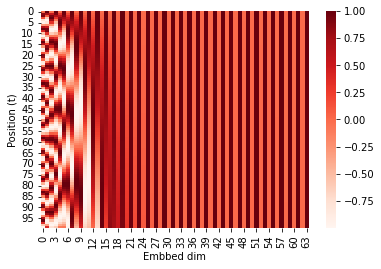

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
T, emb_dim = 100, 64

# Init PE matrix
#    (T, emb_dim)
pe = np.zeros((T, emb_dim))

# Assign pe values
for t in range(T):
    for i in range(0, emb_dim, 2):
        pe[t, i] = np.sin(
            t / (10000 ** ((2 * i) / emb_dim)))
        pe[t, i+1] = np.cos(
            t / (10000 ** ((2 * (i + 1)) / emb_dim)))
        
# Plot
sns.heatmap(pe, cmap=plt.cm.Reds)
plt.xlabel('Embbed dim')
plt.ylabel('Position (t)')
plt.show()

In [10]:
from torch.autograd import Variable

class PositionalEncoder(nn.Module):
    def __init__(self, T, embed_dim):
        super(PositionalEncoder, self).__init__()
        self.emb_dim = embed_dim

        # Init PE matrix
        #    (T, emb_dim)
        pe = torch.zeros(T, self.emb_dim)

        # Assign pe values
        for t in range(T):
            for i in range(0, self.emb_dim, 2):
                pe[t, i] = np.sin(
                    t / (10000 ** ((2 * i) / self.emb_dim)))
                pe[t, i+1] = np.cos(
                    t / (10000 ** ((2 * (i + 1)) / self.emb_dim)))

        # (T, emb_dim) -> (1, T, emb_dim)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, emb):
        """
        Add position encoding info to emb

        Arguments:
            emb (tensor(m, T, embed_dim))       : Embbeding sequence

        Returns:
            emb_pos (tensor(m, T, embed_dim))   : Embbeding + PE sequence
        """
        # Get dim
        T = emb.size(1)
        
        # Retrieve pe
        pe = Variable(self.pe[:,:T], requires_grad=False)
        if emb.is_cuda: pe.cuda()

        # emb_pos = rescaled*emb + position encoded
        emb_pos = np.sqrt(self.emb_dim)*emb + pe
        return emb_pos

In [11]:
pos_encoder_x = PositionalEncoder(
    T=Tx,
    embed_dim=64)

X_emb_pos = pos_encoder_x(X_emb)
print(f'{X_emb_pos.size() = }')

X_emb_pos.size() = torch.Size([16, 50, 64])


In [12]:
pos_encoder_y = PositionalEncoder(
    T=Ty,
    embed_dim=64)

Y_emb_pos = pos_encoder_y(Y_emb)
print(f'{Y_emb_pos.size() = }')

Y_emb_pos.size() = torch.Size([16, 40, 64])


### 1.3 Multi-Headed Attention

#### Masking
- **pad token mask**: Suppress attention where `<pad>` exists
- **No peaking forward Mask**: For Target sequence, prevent the decoder paying attention ahead toward the rest of the translated sentence when predicting the next word.

#### Source mask example

```python
# X_seq = (3, 14), pad_token = 0
X_seq = tensor([
    [ 101, 1045, 2123, 1005, 1056, 2113, 1998, 1045, 2123, 1005, 1056, 2729, 1012,  102],
    [ 101, 2054, 2395, 2079, 2017, 2444, 2006, 1029,  102,    0,    0,    0, 0,    0],
    [ 101, 3419, 5598, 2046, 1996, 4770, 1012,  102,    0,    0,    0,    0, 0,    0]])

# X_mask = (3, 1, 1, 14)
X_mask = tensor([
        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],
        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]],
        [[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]]], dtype=torch.int8)
```

In [13]:
def create_mask_source(X_seq, pad_token, device='cpu'):
    """
    Create mask values (0 = masked, 1 = keep)

    Arguments:
        X_seq (Long tensor(m, T)) : Source Sequence, categorical Long
            m : batch size
            T : sequence length
        pad_token (int)           : token value of <pad>, get from X_lexicon['<pad>']

    Returns:
        mask (Long tensor(m, 1, 1, T)) : attention mask(val=1:keep or val=0:supress) for source sequence
    """
    # Get dim
    m, Tx = X_seq.size()

    # padding token Mask
    #    mask = 1 if seq != padding token else 0
    #    (m, T) -> (m, 1, 1, T)
    padding_mask = (X_seq != pad_token) \
        .unsqueeze(dim=1).unsqueeze(dim=2) \
        .to(device)

    return padding_mask \
        .to(torch.int8).requires_grad_(False)

In [14]:
X_mask = create_mask_source(X, pad_token=X_lexicon['<pad>'])
print(f'{X_mask.size() = }')

X_mask.size() = torch.Size([16, 1, 1, 50])


#### Target mask example

```python
# Y_seq = (3, 12), pad_token = 1
Y_seq = tensor([
    [0, 70, 17, 55, 6, 70, 17,  2665, 25349, 21573, 2, 1],
    [0, 88, 235, 25, 109, 142, 2, 1, 1, 1, 1, 1],
    [0, 33939, 1945, 307, 1005, 1388, 9479, 27375, 2, 1, 1, 1]])

# Y_mask = (3, 1, 12, 12)
Y_mask = tensor([[
         [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]],

        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]],

        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=torch.int8)
```

In [15]:
def create_mask_target(Y_seq, pad_token, device='cpu'):
    """
    Create mask values (0 = masked, 1 = keep)

    Arguments:
        Y_seq (Long tensor(m, T)) : Target Sequence, categorical Long
            m : batch size
            T : sequence length
        pad_token (int)           : token value of <pad>, get from Y_lexicon['<pad>']

    Returns:
        mask (Long tensor(m, 1, T, T)) : attention mask(val=1:keep or val=0:supress) for target sequence
    """
    # Get dim
    m, Ty = Y_seq.size()

    # padding token Mask
    #    mask = 1 if seq != padding token else 0
    #    (m, T) -> (m, 1, 1, T) -> (m, 1, T, T)
    padding_mask = (Y_seq != pad_token) \
        .unsqueeze(dim=1).unsqueeze(dim=2) \
        .expand(m, 1, Ty, Ty).to(torch.bool) \
        .to(device)

    # No peaking forward Mask: (m, 1, T, T)
    #   (T, T) = Lower triangular matrix
    nopeak_mask = torch.tril(torch.ones( (Ty, Ty) )) \
        .unsqueeze(dim=0).unsqueeze(dim=1) \
        .expand(m, 1, Ty, Ty).to(torch.bool) \
        .to(device)

    return (padding_mask & nopeak_mask) \
        .to(torch.int8).requires_grad_(False)

In [16]:
Y_mask = create_mask_target(Y, pad_token=Y_lexicon['<pad>'])
print(f'{Y_mask.size() = }')

Y_mask.size() = torch.Size([16, 1, 40, 40])


#### Scaled Dot-Product Attention

$$\text{Attention}(Q,K,V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V$$

<img src="assets/transformer_SDPAtt.png" width="200">

#### Multi-head Attention

<img src="assets/transformer_multiheadAtt.png" width="300">

In [17]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        # Params
        self.emb_dim = embed_dim
        self.h = num_heads

        # Split emb_dim = num_head * head_dim
        self.head_dim = self.emb_dim // self.h

        assert (
            self.emb_dim == self.h * self.head_dim
        ), "Embedding size needs to be divisible by num_heads"

        # Linear key, queries, values
        self.q_linears = nn.Linear(self.emb_dim, self.emb_dim)
        self.k_linears = nn.Linear(self.emb_dim, self.emb_dim)
        self.v_linears = nn.Linear(self.emb_dim, self.emb_dim)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(num_heads*self.head_dim, self.emb_dim)

    def __scaled_dot_product_att(self, q, k, v, mask=None, dropout=None):
        """
        Compute scaled dot product attention

        Arguments:
            q (tensor(m, T_query, num_heads, head_dim))        : query
            k (tensor(m, T_key, num_heads, head_dim))          : key
            v (tensor(m, T_val, num_heads, head_dim))          : value
            mask (tensor None or (m, 1, T, T) or (m, 1, 1, T)) : attention mask, 1=keep, 0=suppress att
            dropout (None or nn.Dropout)                       : dropout function
        Returns:
            attention (tensor(m, T_query, num_heads, head_dim)): scaled dot product attention
        """
        # energy = (m, T_query, num_heads, head_dim) x (m, T_key, num_heads, head_dim)
        #    -> (m, num_heads, T_query, T_key)
        energy = torch.einsum("mqhd,mkhd->mhqk", [q, k]) / np.sqrt(self.emb_dim)

        if mask is not None:
            # Masking, suppress energy/attention where mask == 0
            energy = energy.masked_fill(mask == 0, float('-1e20'))

        # softmax = (m, num_heads, T_query, T_key)
        energy_sm = F.softmax(energy, dim=3)
        if dropout is not None:
            energy_sm = dropout(energy_sm)

        # attention = softmax * v
        #   (m, T_query, num_heads, head_dim)
        attention = torch.einsum("mhqk,mvhd->mqhd", [energy_sm, v])
        return attention

    def forward(self, Q, K, V, mask=None):
        """
        Compute Multihead attention

        Arguments:
            Q (tensor(m, T_query, emb_dim))        : Query
            K (tensor(m, T_key, emb_dim))          : Key
            V (tensor(m, T_val, emb_dim))          : Value
            mask (tensor None or (m, 1, T, T) or (m, 1, 1, T)) : attention mask, 1=keep, 0=suppress att
        Returns:
            attention (tensor(m, T_query, emb_dim)): multihead attention
        """

        # Batch size
        m = Q.size(0)

        # Compute key, queries, values linears, then split q,k,v -> multiple heads
        #   (m, T_query, emb_dim) -> (m, T_query, num_heads, head_dim)
        #   (m, T_key, emb_dim) -> (m, T_key, num_heads, head_dim)
        #   (m, T_val, emb_dim) -> (m, T_val, num_heads, head_dim)
        queries = self.q_linears(Q).view(m, -1, self.h, self.head_dim)
        keys = self.k_linears(K).view(m, -1, self.h, self.head_dim)
        values = self.v_linears(V).view(m, -1, self.h, self.head_dim)

        # Compute scaled dot product attention
        #    (m, T_query, num_heads, head_dim)
        attention = self.__scaled_dot_product_att(
            q=queries, k=keys, v=values,
            mask=mask, dropout=self.dropout)

        # concatenate all heads
        #    (m, T_query, emb_dim)
        concat = attention.view(m, -1, self.h * self.head_dim)

        # Compute last linear
        attention = self.linear(concat)
        return attention

In [18]:
self_att_x = MultiHeadAttention(embed_dim=64, num_heads=4, dropout=0.1)

X_self_att = self_att_x(Q=X_emb_pos, K=X_emb_pos, V=X_emb_pos, mask=X_mask)
print(f'{X_self_att.size() = }')

X_self_att.size() = torch.Size([16, 50, 64])


In [19]:
self_att_y = MultiHeadAttention(embed_dim=64, num_heads=4, dropout=0.1)

Y_self_att = self_att_y(Q=Y_emb_pos, K=Y_emb_pos, V=Y_emb_pos, mask=Y_mask)
print(f'{Y_self_att.size() = }')

Y_self_att.size() = torch.Size([16, 40, 64])


### 1.4 Layer Norm
- Perform Layer Normalization across each example, agg `feature dimensions`
    + $\gamma$: weight parameter, grad = True
    + $\beta$: bias parameter, grad = True

$$y  = \frac{x - E(x)}{\sqrt{\text{Var}(x) + \epsilon}} * \gamma + \beta$$

In [20]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.eps = eps

        # Trainable params
        self.gamma = nn.Parameter(torch.ones(normalized_shape), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(normalized_shape), requires_grad=True)

    def forward(self, x):
        """
        Compute Norm across each example, agg (emb_dim), same as nn.LayerNorm(emb_dim)

        Arguments:
            x (tensor(m, T, emb_dim))  : Input
            affine (bool)              : If True apply transform to input x
        Returns:
            y (tensor(m, T, emb_dim))  : Norm output
        """
        E_x = x.mean(dim=-1, keepdim=True)
        Var_x = torch.var(x, dim=-1, keepdim=True)
        return (x - E_x) / torch.sqrt(Var_x + self.eps) * self.gamma + self.beta

In [21]:
emb_dim = 64

norm = LayerNorm(normalized_shape=emb_dim, eps=1e-6)

X_norm = norm(X_self_att)
print(f'{X_norm.size() = }')

X_norm.size() = torch.Size([16, 50, 64])


### 1.5 Feed Forward

In [22]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, forward_expansion_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion_dim, embed_dim),
        )
    def forward(self, inp):
        """
        Apply feed forward toward last dimension

        Arguments:
            inp (tensor(m,*,embed_dim))  : Input tensor
        Returns:
            out (tensor(m,*,embed_dim))  : Output tensor
        """
        return self.feed_forward(inp)

In [23]:
feedforward = FeedForward(embed_dim=64, forward_expansion_dim=2048, dropout=0.1)

ff = feedforward(X_norm)
print(f'{ff.size() = }')

ff.size() = torch.Size([16, 50, 64])


# 2. Encoder
### 2.1 Encoder Block

<img src="assets/transformer_blk_encoder.png" width="150">


In [24]:
class EncoderBlock(nn.Module):
    def __init__(self,
            embed_dim, num_heads,
            dropout=0.1, forward_expansion_dim=2048, eps=1e-5):
        super(EncoderBlock, self).__init__()

        # Layer 1
        self.multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_1 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_1 = nn.Dropout(dropout)

        # Layer 2
        self.feed_forward = FeedForward(
            embed_dim=embed_dim, forward_expansion_dim=forward_expansion_dim,
            dropout=dropout)
        self.norm_2 =LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, X_emb_pos, X_mask):
        """
        Arguments:
            X_emb_pos (tensor(m, Tx, emb_dim) : Source sequence encoded with embbeding and position
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
        """
        # Layer 1
        att = self.multihead_attention(
            Q=X_emb_pos, K=X_emb_pos, V=X_emb_pos,
            mask=X_mask)
        X_norm_1 = self.dropout_1(
            self.norm_1(X_emb_pos + att))

        # Layer 2
        ff = self.feed_forward(X_norm_1)
        X_enc = self.dropout_2(
            self.norm_2(X_norm_1 + ff))

        return X_enc

### 2.2 Encoder

<img src="assets/transformer_encoder.png" width="250">

In [25]:
class Encoder(nn.Module):
    def __init__(self,
            Tx, X_lexicon_size, embed_dim,
            num_layers, num_heads,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-5):
        super(Encoder, self).__init__()
        # Params
        self.embed_dim = embed_dim

        # X = emb + pe
        self.input_embedding = Embbeding(
            lexicon_size=X_lexicon_size, embed_dim=embed_dim)
        self.pos_encoding = PositionalEncoder(
            T=Tx, embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Enc blocks
        self.enc_blocks = nn.ModuleList([
            EncoderBlock(
                embed_dim=embed_dim, num_heads=num_heads,
                dropout=dropout, forward_expansion_dim=forward_expansion_dim, eps=eps
            ) for _ in range(num_layers)
        ])

    def forward(self, X_seq, X_mask):
        """
        Arguments:
            X_seq (Long tensor(m, Tx)         : Source sequence, categorical Long
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
        """
        # X = emb + pe
        X_emb = self.input_embedding(X_seq)
        X_emb_pos = self.pos_encoding(X_emb)
        X_enc = self.dropout(X_emb_pos)

        # Enc blocks
        for enc_blk in self.enc_blocks:
            X_enc = enc_blk(
                X_emb_pos=X_enc, X_mask=X_mask)

        return X_enc

In [26]:
encoder = Encoder(
    Tx=Tx, X_lexicon_size=X_lexicon_size, embed_dim=64,
    num_layers=3, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

X_enc = encoder(X_seq=X, X_mask=X_mask)
print(f'{X_enc.size() = }')

X_enc.size() = torch.Size([16, 50, 64])


# 3. Decoder
### 3.1 Decoder Block

<img src="assets/transformer_blk_decoder.png" width="150">

In [27]:
class DecoderBlock(nn.Module):
    def __init__(self,
            embed_dim, num_heads,
            dropout=0.1, forward_expansion_dim=2048, eps=1e-5):
        super(DecoderBlock, self).__init__()
        # Layer 1
        self.masked_multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_1 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_1 = nn.Dropout(dropout)

        # Layer 2
        self.multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_2 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_2 = nn.Dropout(dropout)

        # Layer 3
        self.feed_forward = FeedForward(
            embed_dim=embed_dim, forward_expansion_dim=forward_expansion_dim,
            dropout=dropout)
        self.norm_3 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self,
            Y_emb_pos, Y_mask,
            X_enc, X_mask):
        """
        Arguments:
            Y_emb_pos (tensor(m, Ty, emb_dim) : Target sequence encoded with embbeding and position
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            Y_dec (tensor(m, Ty, emb_dim))     : deccoder output
        """
        # Layer 1
        masked_att = self.masked_multihead_attention(
            Q=Y_emb_pos, K=Y_emb_pos, V=Y_emb_pos,
            mask=Y_mask)
        Y_norm_1 = self.dropout_1(
            self.norm_1(Y_emb_pos + masked_att))

        # Layer 2
        att = self.multihead_attention(
            Q=Y_norm_1, K=X_enc, V=X_enc,
            mask=X_mask)
        Y_norm_2 = self.dropout_2(
            self.norm_2(Y_norm_1 + att))

        # Layer 3
        ff = self.feed_forward(Y_norm_2)
        Y_dec = self.dropout_3(
            self.norm_3(Y_norm_2 + ff))

        return Y_dec

### 3.2 Decoder

<img src="assets/transformer_decoder.png" width="200">

In [28]:
class Decoder(nn.Module):
    def __init__(self,
            Ty, Y_lexicon_size, embed_dim,
            num_layers, num_heads,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-5):
        super(Decoder, self).__init__()
        # Params
        self.embed_dim = embed_dim

        # Y = emb + pe
        self.input_embedding = Embbeding(
            lexicon_size=Y_lexicon_size, embed_dim=embed_dim)
        self.pos_encoding = PositionalEncoder(
            T=Ty, embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Dec blocks
        self.dec_blocks = nn.ModuleList([
             DecoderBlock(
                embed_dim=embed_dim, num_heads=num_heads,
                dropout=dropout, forward_expansion_dim=forward_expansion_dim, eps=eps
            ) for _ in range(num_layers)
        ])

        # Classifier
        self.fc_out = nn.Linear(
            in_features=embed_dim,
            out_features=Y_lexicon_size)

    def forward(self,
            Y_seq, Y_mask,
            X_enc, X_mask):
        """
        Arguments:
            Y_seq (Long tensor(m, Ty)         : Target sequence, categorical Long
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            out (tensor(m, Ty, emb_dim))      : log softmax probability predict category in Y_lexicon
        """
        # Y = emb + pe
        Y_emb = self.input_embedding(Y_seq)
        Y_emb_pos = self.pos_encoding(Y_emb)
        Y_dec = self.dropout(Y_emb_pos)

        # Dec blocks
        for dec_blk in self.dec_blocks:
            Y_dec = dec_blk(
                Y_emb_pos=Y_dec, Y_mask=Y_mask,
                X_enc=X_enc, X_mask=X_mask)

        # Classifier
        out = self.fc_out(Y_dec)
        out = F.log_softmax(out, dim=-1)

        return out

In [29]:
decoder = Decoder(
    Ty=Ty, Y_lexicon_size=Y_lexicon_size, embed_dim=64,
    num_layers=3, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

out = decoder(
    Y_seq=Y, Y_mask=Y_mask,
    X_enc=X_enc, X_mask=X_mask)
print(f'{out.size() = }')

out.size() = torch.Size([16, 40, 14])


# 4. Transformer

In [30]:
class Transformer(nn.Module):
    def __init__(self,
            Tx, X_lexicon_size,
            Ty, Y_lexicon_size,
            embed_dim=512,
            num_layers=3, num_heads=4,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-6):
        super().__init__()
        self.encoder = Encoder(
            Tx=Tx, X_lexicon_size=X_lexicon_size, embed_dim=embed_dim,
            num_layers=num_layers, num_heads=num_heads,
            forward_expansion_dim=forward_expansion_dim,
            dropout=dropout, eps=eps)
        self.decoder = Decoder(
            Ty=Ty, Y_lexicon_size=Y_lexicon_size, embed_dim=embed_dim,
            num_layers=num_layers, num_heads=num_heads,
            forward_expansion_dim=forward_expansion_dim,
            dropout=dropout, eps=eps)

    def forward(self, X_seq, X_mask, Y_seq, Y_mask):
        """
        Arguments:
            X_seq (Long tensor(m, Tx)         : Source sequence, categorical Long
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
            Y_seq (Long tensor(m, Ty)         : Target sequence, categorical Long
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            out (tensor(m, Ty, emb_dim))      : log softmax probability predict category in Y_lexicon
        """
        X_enc = self.encoder(
            X_seq=X_seq, X_mask=X_mask)
        out = self.decoder(
            Y_seq=Y_seq, Y_mask=Y_mask,
            X_enc=X_enc, X_mask=X_mask)
        return out

In [31]:
transformer = Transformer(
    Tx=Tx, X_lexicon_size=X_lexicon_size,
    Ty=Ty, Y_lexicon_size=Y_lexicon_size,
    embed_dim=512,
    num_layers=4, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

out = transformer(
    X_seq=X, X_mask=X_mask,
    Y_seq=Y, Y_mask=Y_mask)
print(f'{out.size() = }')

out.size() = torch.Size([16, 40, 14])


#### Params count

In [32]:
num_params = len(list(transformer.parameters()))

print(f'Number of parameters: {num_params}')

Number of parameters: 172
